In [143]:
#imports 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lars
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler

In [7]:
# Specify the file path
file_path = "ml_data_withstrats.csv"

# Load the CSV file into a pandas DataFrame called df
df = pd.read_csv(file_path)

util = 'calcUtil' # define the target

In [8]:
# FEATURE SELECTION
# list the columns in the dataframe
column_list = df.columns.tolist()

# list of index columns (like ixNest, ixJobSummary, ixPart)
indices = [column for column in column_list if column.startswith('ix')]

# list of strategy type column names 
auto_strategies = [column for column in column_list if column.startswith('AutoStrat')]
f_strategies = [column for column in column_list if column.startswith('fStrat')] 
strategies = [auto_strategies, f_strategies]

nest_data = ['cTimesCut', 'fAllPartsNested', 'cParts', 'dNestingTime', 
             'dLengthUsed', 'dWidthUsed', 'dPartArea']
# cTimesCut - removed, # of times nest will be cut in job, not known in advance 
# fAllPartsNested - removed, just a 0/1 indicator of if all the parts in the job were nested using automatic nesting
# cParts - Total number of parts nested from Nest table - duplicated by cNested, unknown prior to nesting 
# analysis - check if cParts is identical to cNested, what are the differences 
# !! fStrategies might actually be helpful for tree based models - try adding later 
# fStrategies - what is the meaning of this? does it add anything? 
# dNestingTime - analyze later but not a feature 
# dLengthUsed & dWidthUsed - Length/width of plate used by nested parts - not features 
# dPartArea - Total area of nested parts - replicated by dPartTrueArea, from Nest Table 

# exclude the # of parts nested and the # required - not part characteristics 
others = ['cNested', 'cRequired','AutoStrat_IntelliChoice', 'AutoStrat_Rectangular',
          'AutoStrat_rectangular_Optimization', 'AutoStrat_Strategy_1', 'AutoStrat_Strategy_10',
         'AutoStrat_Strategy_2','AutoStrat_Strategy_3','AutoStrat_Strategy_4','AutoStrat_Strategy_5',
         'AutoStrat_Strategy_6','AutoStrat_Strategy_7','AutoStrat_Strategy_8','AutoStrat_Strategy_9',
         'fStrat_BlockNesting','fStrat_BlockOptimization','fStrat_ICPatternFill','fStrat_ICProfileNesting',
          'fStrat_IntelliNest','fStrat_ManualNesting','fStrat_None','fStrat_Strategy1','fStrat_Strategy10',
         'fStrat_Strategy2','fStrat_Strategy3','fStrat_Strategy4','fStrat_Strategy5','fStrat_Strategy6',
         'fStrat_Strategy7','fStrat_Strategy8','fStrat_Strategy9']

# select all the columns that are actually features 
# exclude the auto_strategies for now - just use fstrategies 
non_features = set().union(indices, nest_data, others, auto_strategies)

# Get all columns from the DataFrame as a set
all_columns_set = set(df.columns)

# Subtract the sets of columns you don't want from the set of all columns
selected_columns_set = all_columns_set - non_features
feature_list = list(selected_columns_set) # Convert the resulting set back to a list

# feature list without strategies 
strategies_plus = set().union(indices, nest_data, others, f_strategies, auto_strategies)
columns_nostrats = all_columns_set - strategies_plus
features_nostrats = list(columns_nostrats)

In [9]:
data_original = df.copy() # copy the original dataframe (has all data including non-features)

# make a df with allfeatures (keep only the features in feature_list) 
data = df[feature_list]

# make a df with only part features, not including strats (keep only the features in features_nostrats list)
data_nostrats = df[features_nostrats]

In [10]:
# Fill missing values with the median of the column
# use median because our data is highly skewed & not normally distributed 
data = data.fillna(data.median())

In [13]:
# Remove outliers from the data DataFrame
data = remove_outliers_iqr(data, feature_list)

# Replace 0s with a small value (e.g., 1e9)
data = data.replace(0, 1e9)

# Drop rows with missing values
data = data.dropna()

# Save the filtered DataFrame to a CSV file
data.to_csv('filtered_data.csv', index=False)


In [14]:
# Save a copy of the data DataFrame with outliers
data_with_outliers = data.copy()

# Set the data to the filtered DataFrame without outliers
data_nooutliers = data

# util = target = calcUtil 
X = data_nooutliers.drop(util, axis=1)  # Features
y = data_nooutliers[util]  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression

In [15]:
# Initialize the linear regression model
lr_model = LinearRegression()

# Fit the model to the training data
lr_model.fit(X_train, y_train)

LinearRegression()

In [21]:
# Predict on the testing data
y_pred_lr = lr_model.predict(X_test)

# Calculate evaluation metrics
lr_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'MSE': mean_squared_error(y_test, y_pred_lr),
    'RMSE': mean_squared_error(y_test, y_pred_lr, squared=False),
    'R2': r2_score(y_test, y_pred_lr),
    'Explained Variance': explained_variance_score(y_test, y_pred_lr)
}

# Print the evaluation metrics
for metric_name, metric_value in lr_metrics.items():
    print(f"{metric_name}: {metric_value}")

MAE: 23.623882559102046
MSE: 799.4365548435316
RMSE: 28.274309095776886
R2: 0.050199437642995726
Explained Variance: 0.05019949171558058


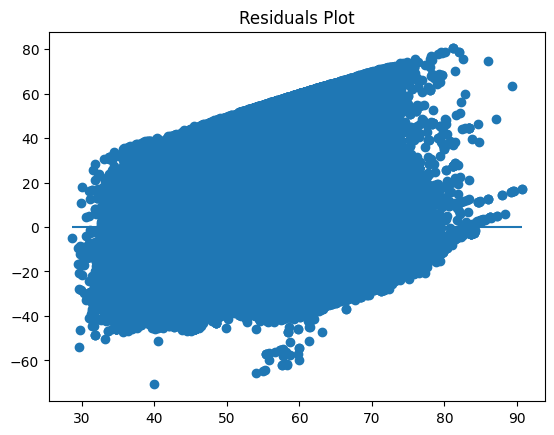

In [38]:
# Plotting residuals
plt.scatter(y_pred, y_pred - y_test)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max())
plt.title('Residuals Plot')
plt.show()

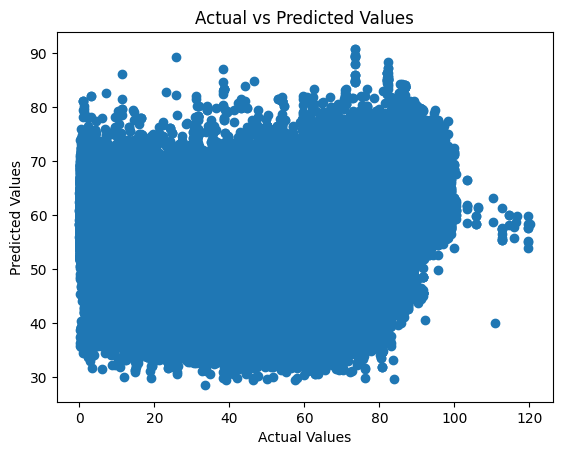

In [41]:
# Plotting predicted vs actual values
plt.scatter(y_test, y_pred_lr)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

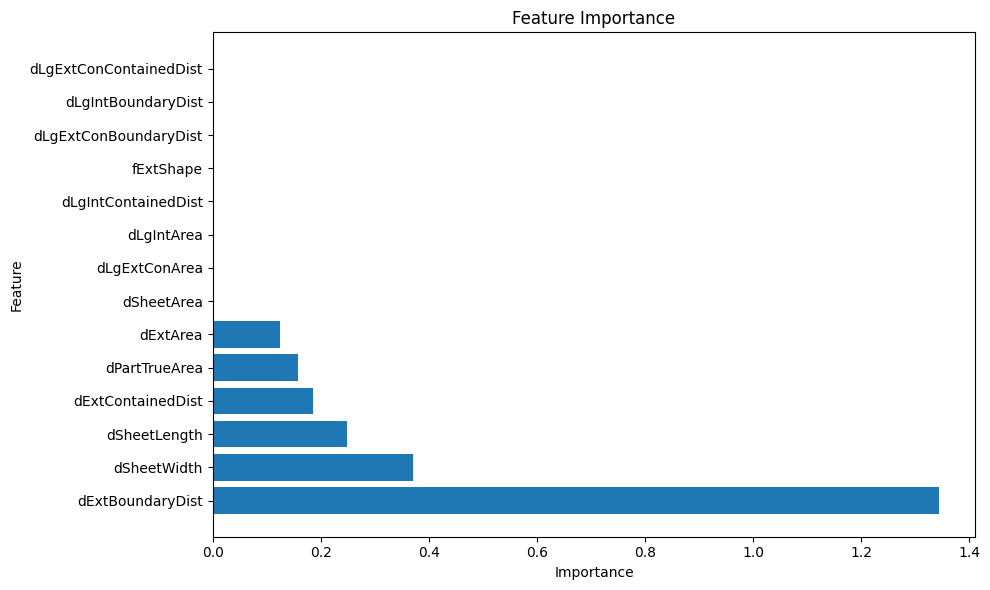

In [105]:
# Get the feature importances
importance = np.abs(lr_model.coef_)

# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

Least Angle Regression

In [43]:
# Initialize the LARS model
lars_model = Lars()

# Fit the model to the training data
lars_model.fit(X_train, y_train)

Lars()

In [44]:
# Predict on the testing data
y_pred_lars = lars_model.predict(X_test)

# Calculate evaluation metrics
lars_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'MSE': mean_squared_error(y_test, y_pred_lr),
    'RMSE': mean_squared_error(y_test, y_pred_lr, squared=False),
    'R2': r2_score(y_test, y_pred_lr),
    'Explained Variance': explained_variance_score(y_test, y_pred_lr)
}

# Print the evaluation metrics
for metric_name, metric_value in lars_metrics.items():
    print(f"{metric_name}: {metric_value}")

MAE: 23.623882559102046
MSE: 799.4365548435316
RMSE: 28.274309095776886
R2: 0.050199437642995726
Explained Variance: 0.05019949171558058


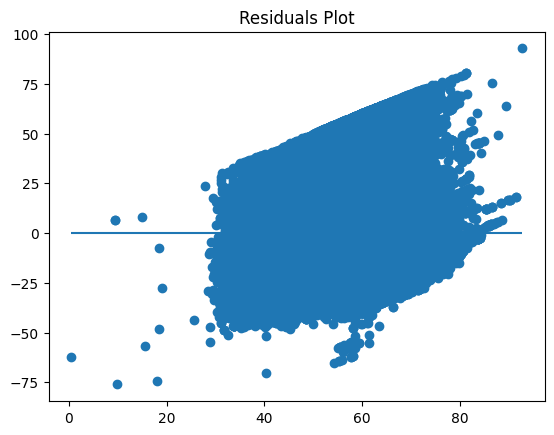

In [45]:
# Plotting residuals
plt.scatter(y_pred_lars, y_pred_lars - y_test)
plt.hlines(y=0, xmin=y_pred_lars.min(), xmax=y_pred_lars.max())
plt.title('Residuals Plot')
plt.show()

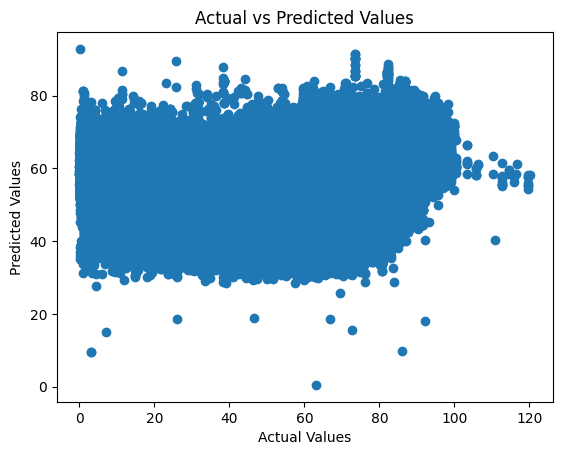

In [46]:
# Plotting predicted vs actual values
plt.scatter(y_test, y_pred_lars)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

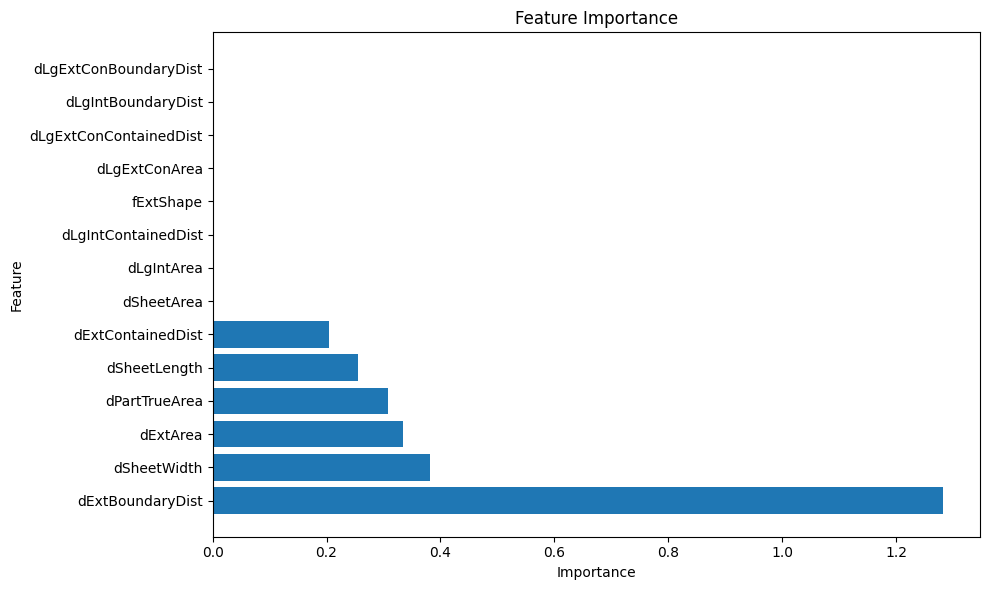

In [104]:
# Get the feature importances
importance = np.abs(lars_model.coef_)

# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

Decision Tree Regressor

In [110]:

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)


DecisionTreeRegressor()

In [83]:
# Predict on the testing data
y_pred_tree = tree_model.predict(X_test)

# Calculate evaluation metrics
tree_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_tree),
    'MSE': mean_squared_error(y_test, y_pred_tree),
    'RMSE': mean_squared_error(y_test, y_pred_tree, squared=False),
    'R2': r2_score(y_test, y_pred_tree),
    'Explained Variance': explained_variance_score(y_test, y_pred_tree)
}

# Print the evaluation metrics
for metric_name, metric_value in tree_metrics.items():
    print(f"{metric_name}: {metric_value}")

MAE: 8.141145968539352
MSE: 331.7498169319133
RMSE: 18.214000574610544
R2: 0.6058521958062874
Explained Variance: 0.6059373946237849


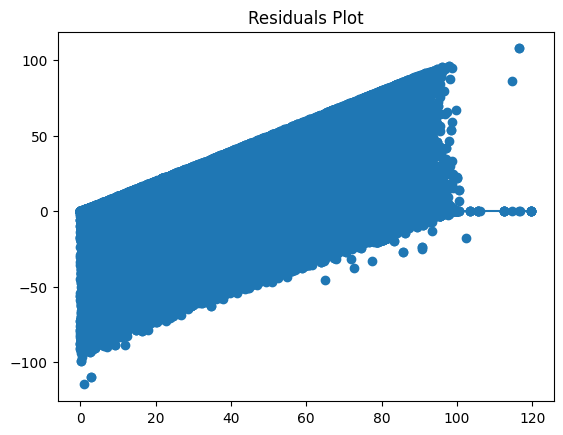

In [80]:
# Plotting residuals
plt.scatter(y_pred_tree, y_pred_tree - y_test)
plt.hlines(y=0, xmin=y_pred_tree.min(), xmax=y_pred_tree.max())
plt.title('Residuals Plot')
plt.show()

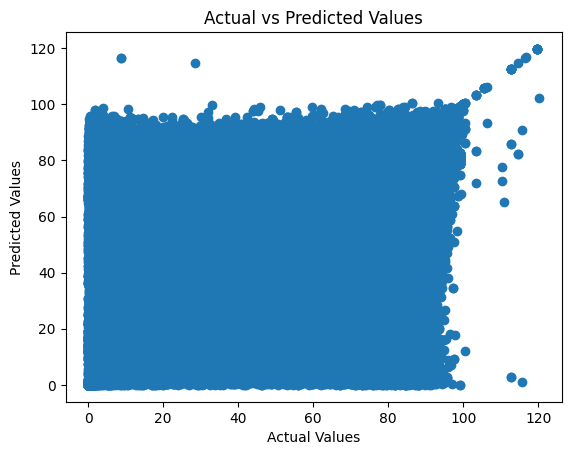

In [84]:
# Plotting predicted vs actual values
plt.scatter(y_test, y_pred_tree)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

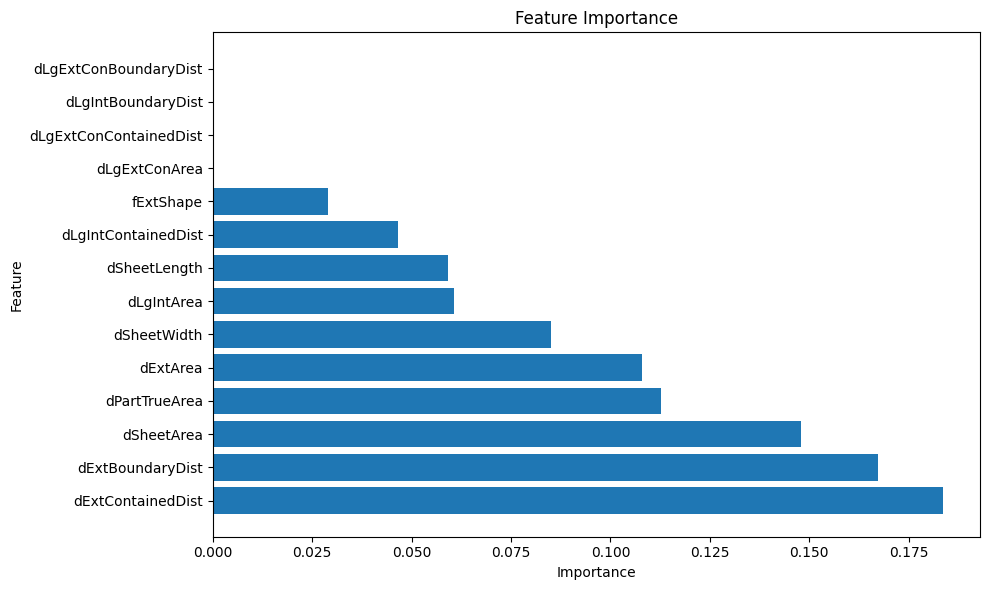

In [86]:
# Get the feature importances
importance = tree_model.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


Passive Aggressive Regressor

In [88]:
# Create an instance of the Passive Aggressive Regressor
regressor = PassiveAggressiveRegressor()

# Fit the model to the training data
regressor.fit(X_train, y_train)



PassiveAggressiveRegressor()

In [89]:
# Predict on the testing data
y_pred_regressor = regressor.predict(X_test)

# Calculate evaluation metrics
regressor_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_regressor),
    'MSE': mean_squared_error(y_test, y_pred_regressor),
    'RMSE': mean_squared_error(y_test, y_pred_regressor, squared=False),
    'R2': r2_score(y_test, y_pred_regressor),
    'Explained Variance': explained_variance_score(y_test, y_pred_regressor)
}

# Print the evaluation metrics
for metric_name, metric_value in regressor_metrics.items():
    print(f"{metric_name}: {metric_value}")

MAE: 51.7153605296724
MSE: 3604.647510011428
RMSE: 60.03871675853364
R2: -3.282636578681003
Explained Variance: -0.10650487953879995


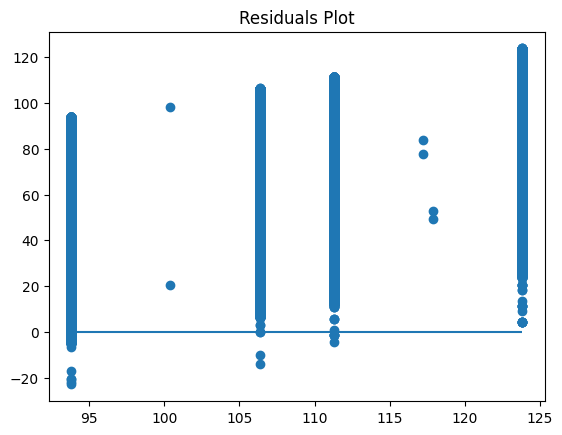

In [90]:
# Plotting residuals
plt.scatter(y_pred_regressor, y_pred_regressor - y_test)
plt.hlines(y=0, xmin=y_pred_regressor.min(), xmax=y_pred_regressor.max())
plt.title('Residuals Plot')
plt.show()

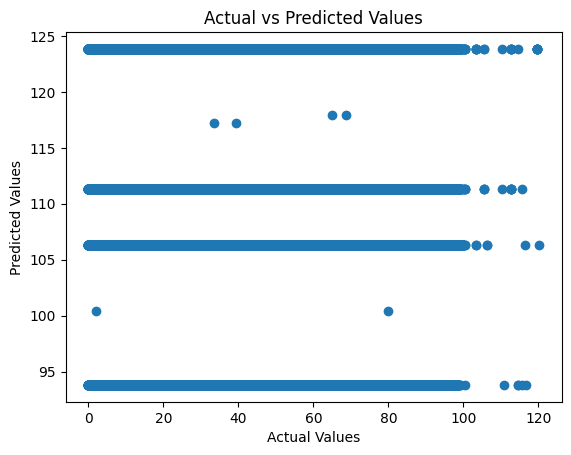

In [91]:
# Plotting predicted vs actual values
plt.scatter(y_test, y_pred_regressor)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

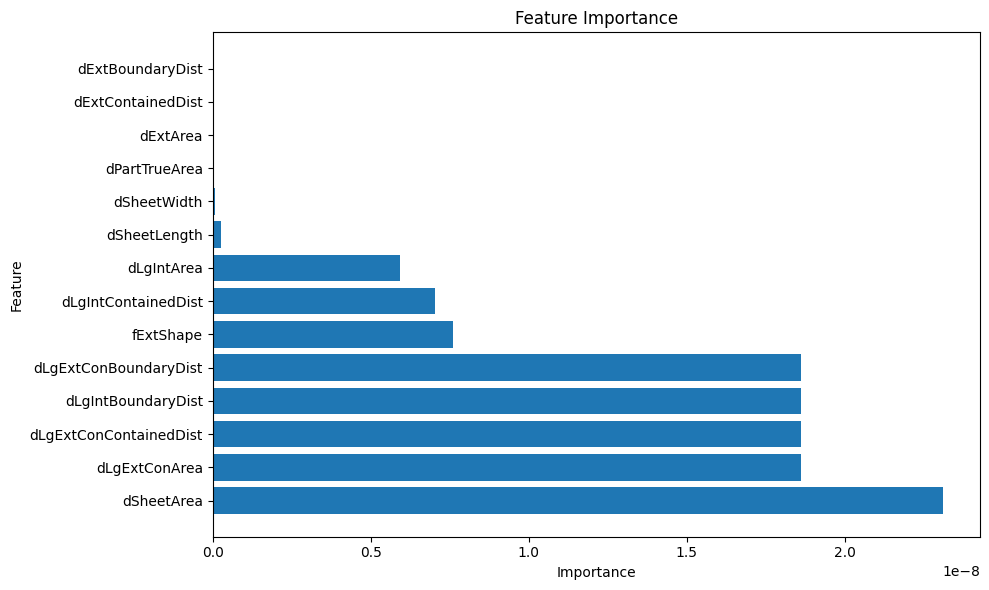

In [103]:
# Get the absolute coefficients
importance = np.abs(regressor.coef_)

# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


In [95]:
BayesianRidge = BayesianRidge()
BayesianRidge.fit(X_train, y_train)


BayesianRidge()

In [96]:
# Predict on the testing data
y_pred_BayesianRidge = BayesianRidge.predict(X_test)

# Calculate evaluation metrics
BayesianRidge_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_BayesianRidge),
    'MSE': mean_squared_error(y_test, y_pred_BayesianRidge),
    'RMSE': mean_squared_error(y_test, y_pred_BayesianRidge, squared=False),
    'R2': r2_score(y_test, y_pred_BayesianRidge),
    'Explained Variance': explained_variance_score(y_test, y_pred_BayesianRidge)
}

# Print the evaluation metrics
for metric_name, metric_value in BayesianRidge_metrics.items():
    print(f"{metric_name}: {metric_value}")

MAE: 23.62391633590737
MSE: 799.4351603707199
RMSE: 28.274284436051072
R2: 0.05020109439868514
Explained Variance: 0.050201148226491576


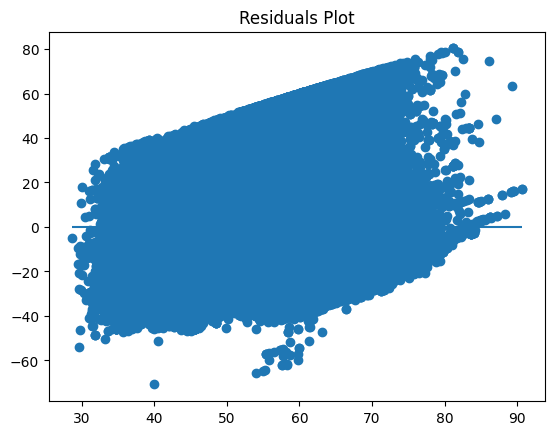

In [97]:
# Plotting residuals
plt.scatter(y_pred_BayesianRidge, y_pred_BayesianRidge - y_test)
plt.hlines(y=0, xmin=y_pred_BayesianRidge.min(), xmax=y_pred_BayesianRidge.max())
plt.title('Residuals Plot')
plt.show()

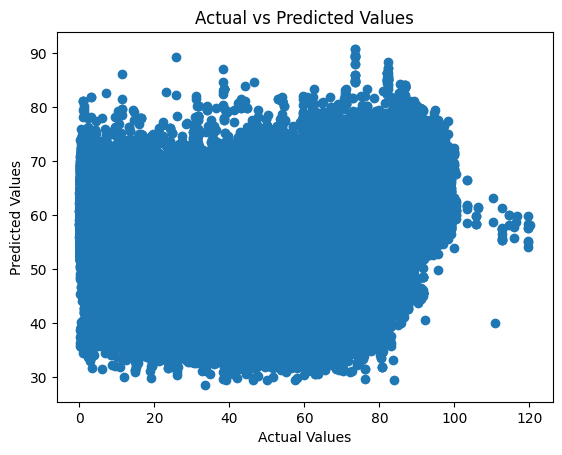

In [98]:
# Plotting predicted vs actual values
plt.scatter(y_test, y_pred_BayesianRidge)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

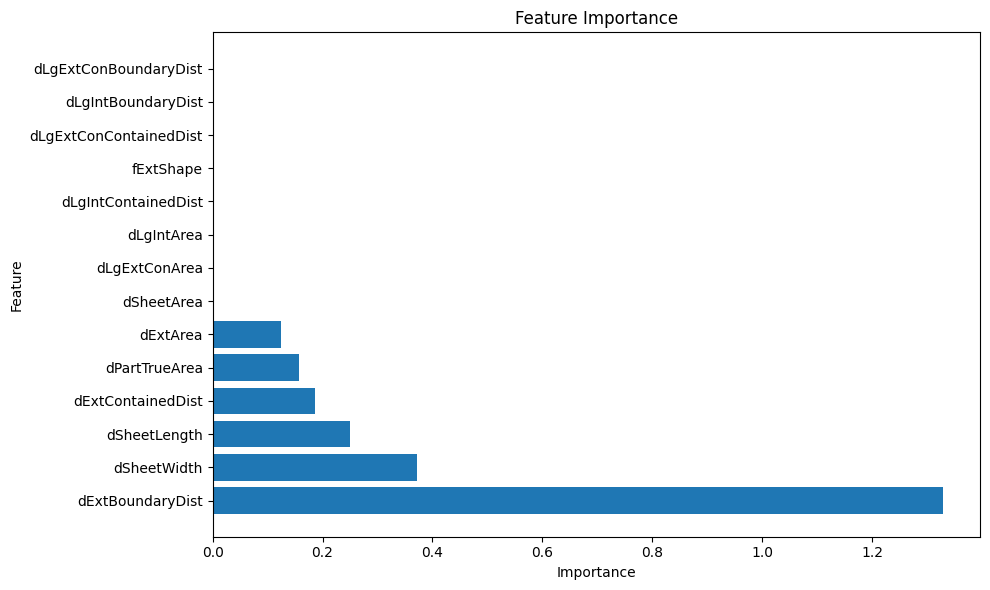

In [102]:
# Get the feature importances (coefficients)
importance = np.abs(BayesianRidge.coef_)

# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


Lasso Regression

In [111]:
# Create and fit the Lasso Regression model
lasso_model = Lasso()  
lasso_model.fit(X_train, y_train)


/Users/ashauntehill/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.524e+08, tolerance: 7.388e+04
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [112]:
# Predict on the testing data
y_pred_lasso = lasso_model.predict(X_test)

# Calculate evaluation metrics
y_lasso_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_lasso),
    'MSE': mean_squared_error(y_test, y_pred_lasso),
    'RMSE': mean_squared_error(y_test, y_pred_lasso, squared=False),
    'R2': r2_score(y_test, y_pred_lasso),
    'Explained Variance': explained_variance_score(y_test, y_pred_lasso)
}

# Print the evaluation metrics
for metric_name, metric_value in y_lasso_metrics.items():
    print(f"{metric_name}: {metric_value}")

MAE: 23.64536450007522
MSE: 800.2599823921611
RMSE: 28.288866756944525
R2: 0.0492211336812739
Explained Variance: 0.04922116384696984


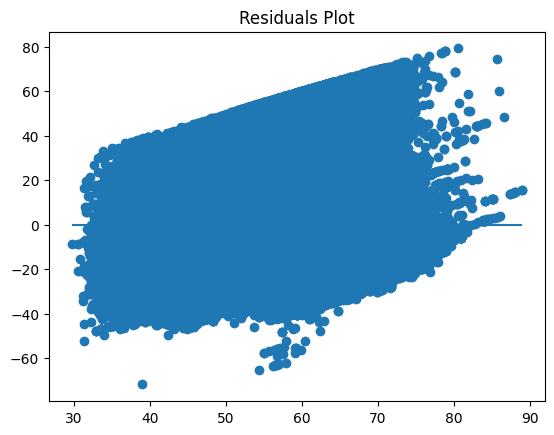

In [113]:
# Plotting residuals
plt.scatter(y_pred_lasso, y_pred_lasso - y_test)
plt.hlines(y=0, xmin=y_pred_lasso.min(), xmax=y_pred_lasso.max())
plt.title('Residuals Plot')
plt.show()

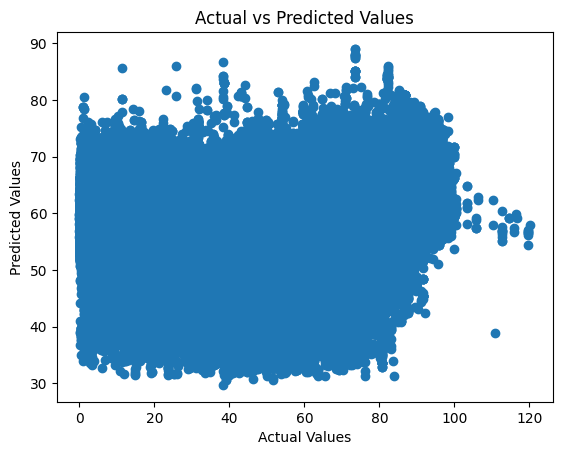

In [114]:
# Plotting predicted vs actual values
plt.scatter(y_test, y_pred_lasso)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

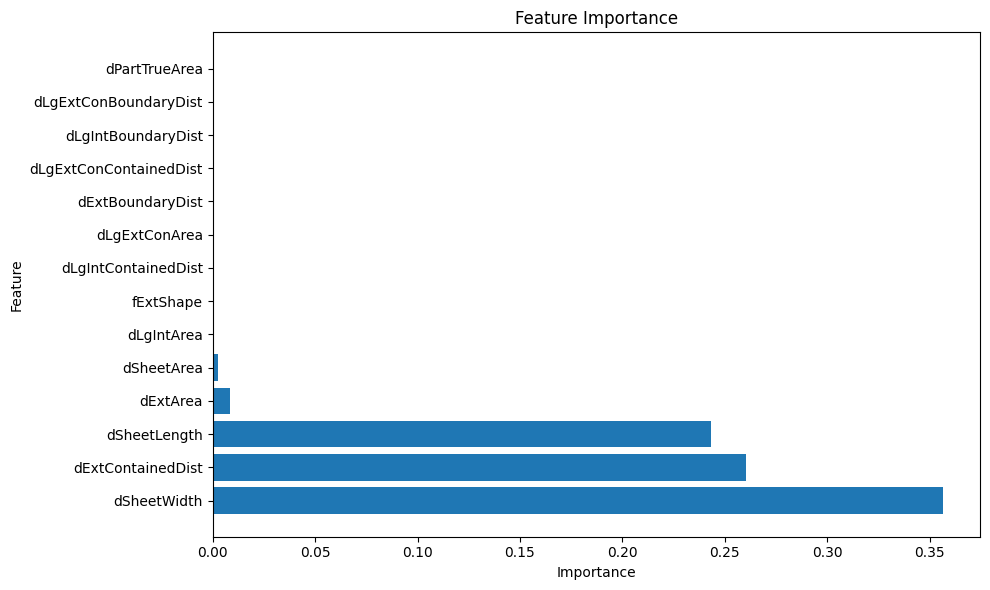

In [115]:
# Get the feature importances (coefficients)
importance = np.abs(lasso_model.coef_)

# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


Huber Model

In [116]:
# Create and fit the Huber Regressor model
huber_model = HuberRegressor()  
huber_model.fit(X_train, y_train)

HuberRegressor()

In [117]:
# Predict on the testing data
y_pred_huber = huber_model.predict(X_test)

# Calculate evaluation metrics
y_huber_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_huber),
    'MSE': mean_squared_error(y_test, y_pred_huber),
    'RMSE': mean_squared_error(y_test, y_pred_huber, squared=False),
    'R2': r2_score(y_test, y_pred_huber),
    'Explained Variance': explained_variance_score(y_test, y_pred_huber)
}

# Print the evaluation metrics
for metric_name, metric_value in y_huber_metrics.items():
    print(f"{metric_name}: {metric_value}")

MAE: 22.606691864159988
MSE: 964.4669203530099
RMSE: 31.055867728225046
R2: -0.14587107354042583
Explained Variance: 0.0007537772994445913


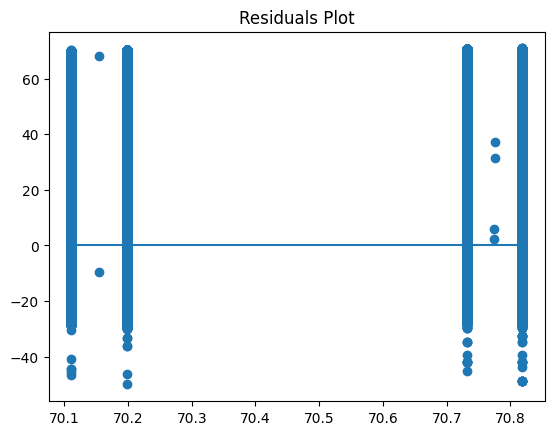

In [118]:
# Plotting residuals
plt.scatter(y_pred_huber, y_pred_huber - y_test)
plt.hlines(y=0, xmin=y_pred_huber.min(), xmax=y_pred_huber.max())
plt.title('Residuals Plot')
plt.show()

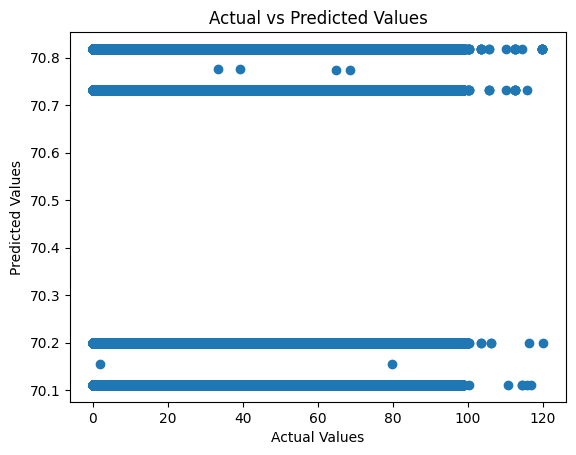

In [119]:
# Plotting predicted vs actual values
plt.scatter(y_test, y_pred_huber)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

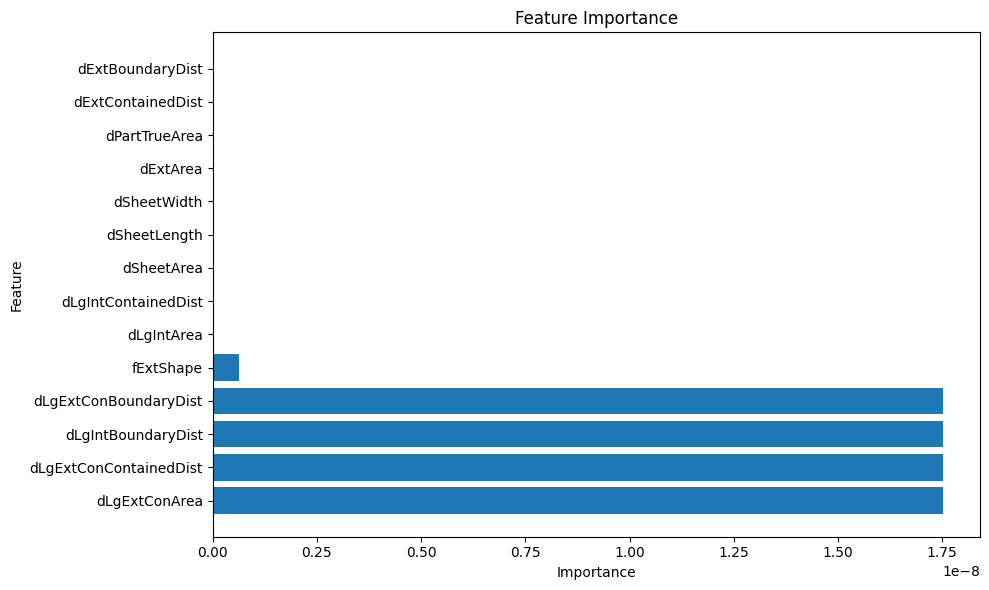

In [120]:
# Get the feature importances (coefficients)
importance = np.abs(huber_model.coef_)

# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

Orthogonal Matching Pursuit model

In [ ]:
# Create and fit the Orthogonal Matching Pursuit model
omp_model = OrthogonalMatchingPursuit()
omp_model.fit(X_train, y_train)

In [122]:
# Predict on the testing data
y_pred_omp = omp_model.predict(X_test)

# Calculate evaluation metrics
y_omp_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_omp),
    'MSE': mean_squared_error(y_test, y_pred_omp),
    'RMSE': mean_squared_error(y_test, y_pred_omp, squared=False),
    'R2': r2_score(y_test, y_pred_omp),
    'Explained Variance': explained_variance_score(y_test, y_pred_omp)
}

# Print the evaluation metrics
for metric_name, metric_value in y_omp_metrics.items():
    print(f"{metric_name}: {metric_value}")

MAE: 24.508238671911492
MSE: 840.4241040987847
RMSE: 28.99006905991748
R2: 0.0015026435116659576
Explained Variance: 0.0015026535534204966


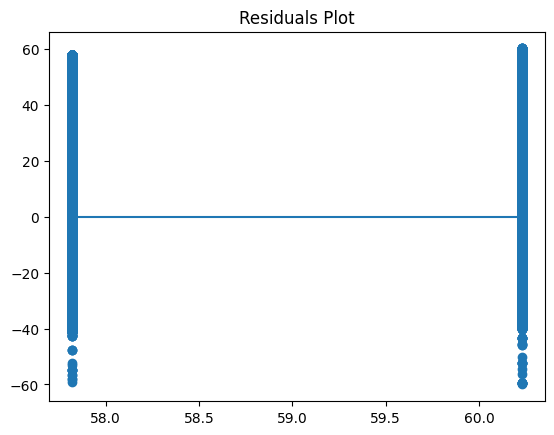

In [123]:
# Plotting residuals
plt.scatter(y_pred_omp, y_pred_omp - y_test)
plt.hlines(y=0, xmin=y_pred_omp.min(), xmax=y_pred_omp.max())
plt.title('Residuals Plot')
plt.show()

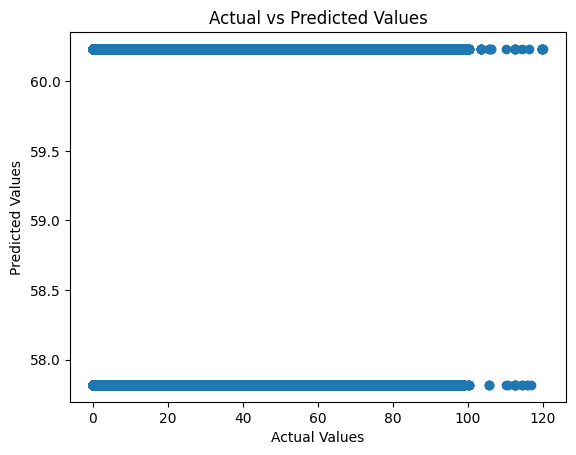

In [124]:
# Plotting predicted vs actual values
plt.scatter(y_test, y_pred_omp)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

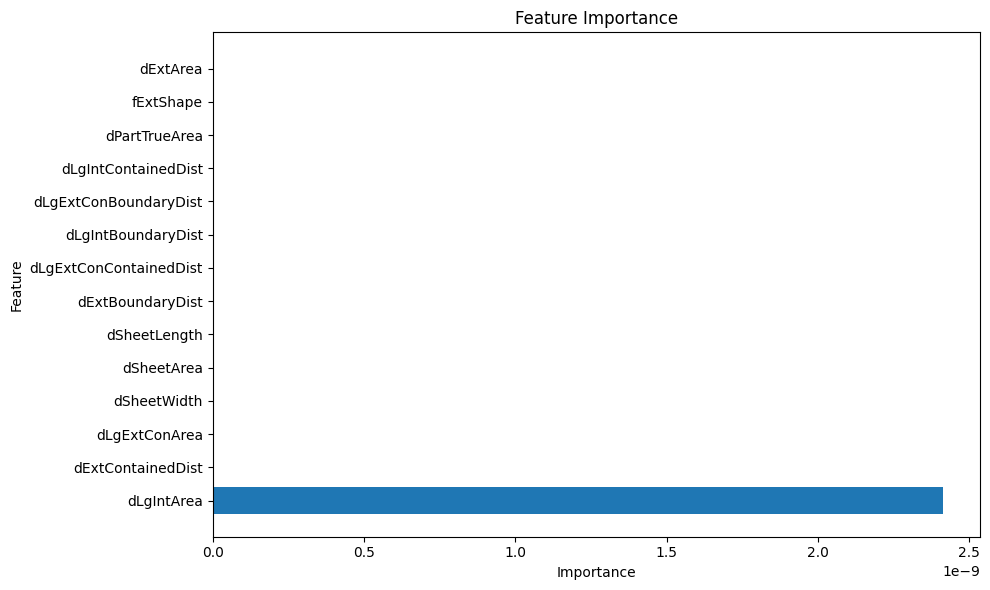

In [127]:
# Get the feature importances (coefficients)
importance = np.abs(omp_model.coef_)

# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


In [150]:
# Create a DataFrame from the metrics dictionaries
metrics_df = pd.DataFrame({'LR Model': lr_metrics, 'LARS Model': lars_metrics, 'Decision Tree Regressor': tree_metrics,
                           'Passive Agressive Regressor': regressor_metrics, 'Bayesian Ridge': BayesianRidge_metrics,
                           'Lasso Regression': y_lasso_metrics, 'Huber Regressor': y_huber_metrics, 'Orthogonal Matching Pursuit': y_omp_metrics,
                          'Gradient Boosting Regressor model': y_gb_model_metrics})

# Set the index name
metrics_df.index.name = 'Metrics'

# Format the values in the DataFrame
metrics_df = metrics_df.round(4)  # Round the values to 4 decimal places

# Apply formatting to the DataFrame
styled_df = metrics_df.style.set_properties(**{
    'text-align': 'center',
    'border-color': 'lightgray',
    'border-style': 'solid',
    'border-width': '1px'
}).set_table_styles([{
    'selector': 'th',
    'props': [('background-color', 'lightgray')]
}])

# Display the styled DataFrame
display(styled_df)


,LR Model,LARS Model,Decision Tree Regressor,Passive Agressive Regressor,Bayesian Ridge,Lasso Regression,Huber Regressor,Orthogonal Matching Pursuit,Gradient Boosting Regressor model
Metrics,,,,,,,,,
MAE,23.623900,23.623900,8.141100,51.715400,23.623900,23.645400,22.606700,24.508200,21.636800
MSE,799.436600,799.436600,331.749800,3604.647500,799.435200,800.260000,964.466900,840.424100,706.290400
RMSE,28.274300,28.274300,18.214000,60.038700,28.274300,28.288900,31.055900,28.990100,26.576100
R2,0.050200,0.050200,0.605900,-3.282600,0.050200,0.049200,-0.145900,0.001500,0.160900
Explained Variance,0.050200,0.050200,0.605900,-0.106500,0.050200,0.049200,0.000800,0.001500,0.160900


In [142]:
# LightGBM 
# TabNet

In [144]:
# Initialize the Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor()

# Fit the model to the training data
gb_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [145]:
# Predict on the testing data
y_pred_gb_model = gb_model.predict(X_test)

# Calculate evaluation metrics
y_gb_model_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_gb_model ),
    'MSE': mean_squared_error(y_test, y_pred_gb_model ),
    'RMSE': mean_squared_error(y_test, y_pred_gb_model , squared=False),
    'R2': r2_score(y_test, y_pred_gb_model ),
    'Explained Variance': explained_variance_score(y_test, y_pred_gb_model )
}

# Print the evaluation metrics
for metric_name, metric_value in y_gb_model_metrics.items():
    print(f"{metric_name}: {metric_value}")

MAE: 21.63682599179485
MSE: 706.2904478132649
RMSE: 26.576125522981428
R2: 0.16086516127384543
Explained Variance: 0.16086574429800526


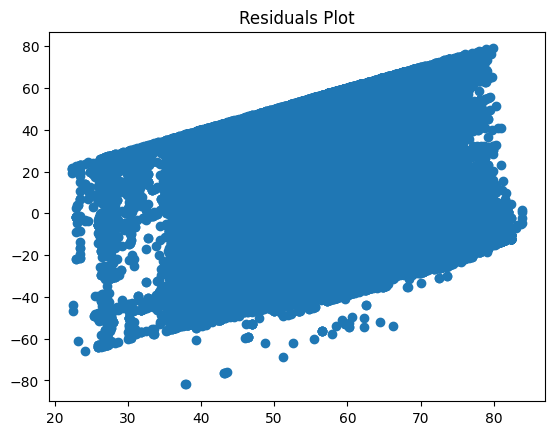

In [146]:
# Plotting residuals
plt.scatter(y_pred_gb_model, y_pred_gb_model - y_test)
plt.hlines(y=0, xmin=y_pred_omp.min(), xmax=y_pred_omp.max())
plt.title('Residuals Plot')
plt.show()

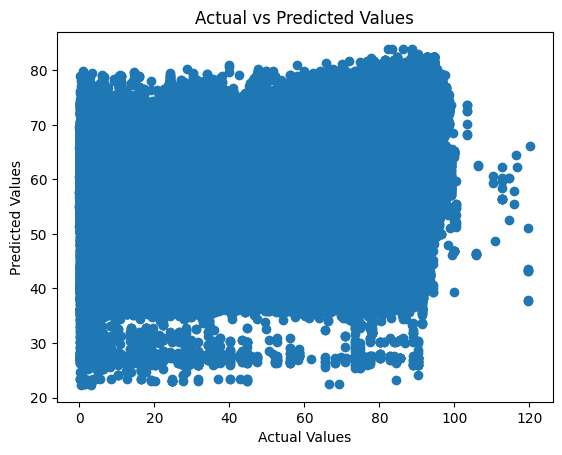

In [147]:
# Plotting predicted vs actual values
plt.scatter(y_test, y_pred_gb_model)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

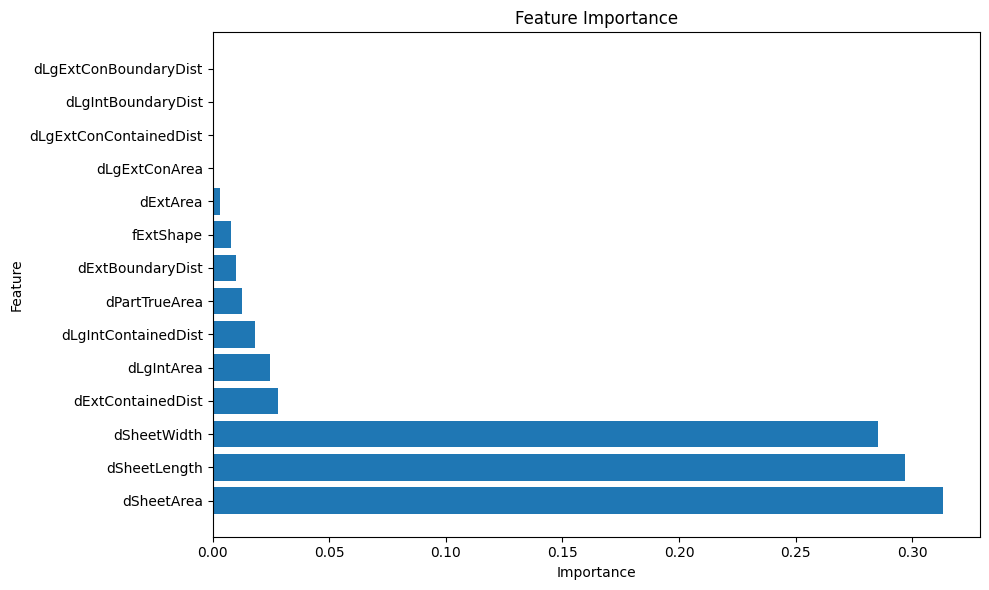

In [149]:
importance = np.abs(gb_model.feature_importances_)
# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()